In [1]:
include("./param.jl");
include("./aux_functions.jl");

2021-05-28 18:52:56.884369: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll


In [2]:
using Main.aux_functions
using Main.param

In [3]:
using ADCME
using SparseArrays

using DelimitedFiles
using Dates
using Plots

In [4]:
param_model_val = param_model(N_steps=3);
tf_variables, h_t, q_t_x, q_t_y = Darcy_flow_solver(param_model_val);
# momment2, y_x_list, y_y_list = load_QoIs(param_model_val);

In [5]:
    function loss_function(lambda,p,y_t,q_t)
    
        q_t = tf.slice(q_t,constant([0,0,0],dtype=Int32),constant([-1,-1,1],dtype=Int32))

        dw = tf.squared_difference(constant(reshape(transpose(y_t),(model_param.N_steps,model_param.N_k_fine,1))),constant(reshape(q_t,(model_param.N_steps,1,model_param.N_k))))

        dw_2_sum = tf.reduce_mean(dw) 

        dw_2_mean = tf.reduce_sum(tf.reduce_mean(dw,axis=0).*p)/model_param.N_k_fine

        momment2 = reshape(std(y_t,dims=1),(model_param.N_steps,1,1)).^2;

        dw = tf.reduce_sum(dw ./ momment2,axis=0)
        # dw = tf.reduce_sum(dw ,axis=0)

        dw_min = tf.reduce_min(dw,1,keepdims=true)
        dw_m_min = -dw + dw_min

        F = p .* tf.exp(dw_m_min/lambda)

        F = tf.reduce_sum(F,1,keep_dims=true)

        F = tf.log(F)- dw_min/lambda

        loss = - tf.reduce_sum(F)/model_param.N_k_fine

        return loss , dw_2_sum
    end

loss_function (generic function with 1 method)

In [12]:
#     # function Info_upscale(tf_variables,model_param,q_t_x, q_t_y,maxiter=400)
maxiter=50


model_param =param_model_val
momment2, y_x_list, y_y_list = load_QoIs(model_param)


N_k_dis_ = 4
p_pre_soft_max_values = ones(1,model_param.N_k) .+ (1e0 .* rand(1,model_param.N_k)) ;




for i = 1:N_k_dis_
    p_pre_soft_max_values[1,i] +=100
end
print(momment2)
p_pre_soft_max = tf.Variable(p_pre_soft_max_values)
p = tf.nn.softmax(p_pre_soft_max,1)

sess = Session(); init(sess);



loss_x_list = [loss_function(tf_variables.lambda,p,y_x_list[ii],q_t_x[ii]) for ii = 1:model_param.N_points]
loss_y_list = [loss_function(tf_variables.lambda,p,y_y_list[ii],q_t_y[ii]) for ii = 1:model_param.N_points];

loss_x = loss_x_list[5][1] #+ loss_x_list[4][1] 
loss_y = loss_y_list[5][1] #+ loss_y_list[4][1] 
loss = loss_x + loss_y 

dw_x = loss_x_list[5][2]# + loss_x_list[4][2] 
dw_y = loss_y_list[5][2]# + loss_x_list[4][2] 


dw_2_sum = dw_x + dw_y

# sort_list = [tf.sort(tf.slice(q_t_x[ii],[0,0,0],[model_param.N_steps,tf_variables.N_k_dis,1]),axis=1) for ii=5]
# diff_list = [tf.reduce_max(tf.reduce_min((tf.slice(sort_list[ii],[0,1,0],[-1,-1,-1])-
# (tf.slice(sort_list[ii],[0,0,0],[-1,tf_variables.N_k_dis-1,-1])))./tf.reduce_mean(sort_list[ii],axis=1,keep_dims=true),axis=1)) for ii =1]
# diff_eval =  tf.reduce_max(tf.stack(diff_list))

# opt_ADAM = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss* 1e5) 
# opt_LFGS = ScipyOptimizerInterface(loss* 1e5; method="L-BFGS-B", options=Dict("maxiter"=> 400, "ftol"=>1e-10, "gtol"=>1e-8))
# opt_ADAM_sum = tf.train.AdamOptimizer(learning_rate=0.001).minimize(dw_2_sum)
# opt_LFGS_sum = ScipyOptimizerInterface(dw_2_sum * 1e5; method="L-BFGS-B", options=Dict("maxiter"=> maxiter, "ftol"=>1e-12, "gtol"=>1e-16))



# loss,dw_2, opt_ADAM, opt_LFGS, opt_ADAM_sum, opt_LFGS_sum, diff_eval,p_pre_soft_max, p = Info_upscale(tf_variables,param_model_val,q_t_x, q_t_y,100)


    #     return loss_y,dw_2_sum , opt_ADAM, opt_LFGS, opt_ADAM_sum, opt_LFGS_sum, diff_eval,p_pre_soft_max, p
    # end

2.830469177224561e-52021-05-28 18:54:45.974638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1650 major: 7 minor: 5 memoryClockRate(GHz): 1.56
pciBusID: 0000:01:00.0
2021-05-28 18:54:45.974726: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2021-05-28 18:54:45.974750: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2021-05-28 18:54:45.974767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll
2021-05-28 18:54:45.974786: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library curand64_100.dll
2021-05-28 18:54:45.974802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusolver64_100.dll
2021-05-28 18:54:45.974824: I tensorflow/stre

PyObject <tf.Tensor 'add_93:0' shape=() dtype=float64>

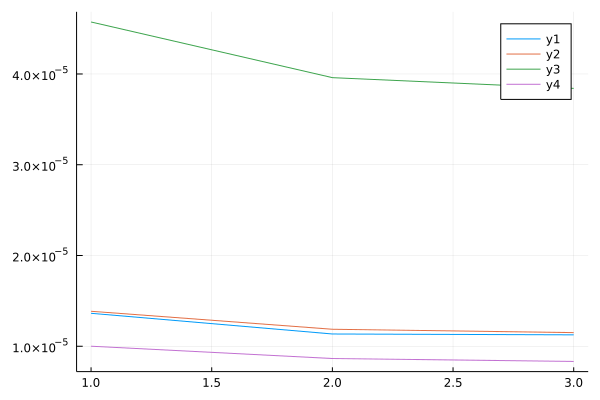

In [41]:
run(sess,loss)
q_check = run(sess,q_t_x)[5];
p_check = run(sess,p);


plot(mean(y_x_list[5],dims=1)[1,:])
# plot!(q_check[:,3,1])
plot!(sum(q_check .* p_check,dims=2)[:,1,1])

plot!(maximum(q_check,dims=2)[:,1,1])
plot!(minimum(q_check,dims=2)[:,1,1])



In [8]:

# check_diff_ = run(sess,diff_eval,feed_dict = Dict(tf_variables.lambda => ones(1)*1,tf_variables.N_k_dis=>64))  
# N_k_dis_ = aux_functions.update_K_p(sess,param_model_val,tf_variables,check_diff_,64,p_pre_soft_max)


# p_check[1:5]
run(sess,dw_x)


8.691417107720527e-9

In [9]:
p_check
# q_check[:,1:4,1]

1×64 Matrix{Float64}:
 0.237371  0.279935  0.300246  0.182448  …  6.60048e-45  8.37765e-45

In [13]:
BFGS!(sess,dw_2_sum*1e5,options=Dict("maxiter"=> 50, "ftol"=>1e-18, "gtol"=>1e-18))


C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
┌ Info: Optimization starts...
└ @ ADCME C:\Users\dbeli\.julia\packages\ADCME\cupNK\src\optim.jl:332
iter 0, current loss=0.0008692868851235105
iter 1, current loss=0.0007252581875035199
================ STEP 0 ===============
iter 2, current loss=0.0002833208421319919
================ STEP 1 ===============
iter 3, current loss=0.00014297654466699194
================ STEP 2 ===============
iter 4, current loss=6.099919295014837e-5
================ STEP 3 ===============
iter 5, current loss=2.7182743996802383e-5
================ STEP 4 ===============
iter 6, current loss=1.2790077869033381e-5
================ STEP 5 ===============
iter 7, current loss=7.563046114914785e-6
================ 

50-element Vector{Any}:
 0.0007252581875035199
 0.0002833208421319919
 0.00014297654466699194
 6.099919295014837e-5
 2.7182743996802383e-5
 1.2790077869033381e-5
 7.563046114914785e-6
 5.95121285171931e-6
 5.571597865195358e-6
 5.509352686575504e-6
 5.497159627124283e-6
 5.481778354260141e-6
 5.456426798357546e-6
 ⋮
 5.400164210221562e-6
 5.400145305401639e-6
 5.4001109438424596e-6
 5.399936287628231e-6
 5.399847756460426e-6
 5.399749937554872e-6
 5.399643791463627e-6
 5.399540969566524e-6
 5.399409702765647e-6
 5.399371785029142e-6
 5.399237348938944e-6
 5.399198693354259e-6

In [40]:
# BFGS!(sess,loss*1e5,options=Dict("maxiter"=> 12, "ftol"=>1e-18, "gtol"=>1e-18))
BFGS!(sess,loss*1e15,options=Dict("maxiter"=> 100, "ftol"=>1e-12, "gtol"=>1e-12),feed_dict = Dict(tf_variables.lambda => ones(1)*1e0,tf_variables.N_k_dis=>8))


C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
┌ Info: Optimization starts...
└ @ ADCME C:\Users\dbeli\.julia\packages\ADCME\cupNK\src\optim.jl:332
iter 0, current loss=5.951373788947781e15
iter 1, current loss=5.412523808210669e15
iter 2, current loss=5.951373787093723e15
iter 3, current loss=5.223811174619806e15
iter 4, current loss=5.305337302806063e15
iter 5, current loss=5.130302445184474e15
iter 6, current loss=5.13013656866739e15
iter 7, current loss=5.130136306586389e15
================ STEP 0 ===============
iter 8, current loss=5.662538101898143e15
iter 9, current loss=5.130136306472796e15
================ STEP 1 ===============
iter 10, current loss=5.130084826244282e15
iter 11, current loss=5.129878913110922e15
iter 12, curren

100-element Vector{Any}:
 5.130136306586389e15
 5.130136306472796e15
 4.863370050028363e15
 4.133440406081527e15
 3.337081433404819e15
 3.13456119784786e15
 3.0213863524035095e15
 2.813728566066243e15
 2.767464436573966e15
 2.7368796424486135e15
 2.720529259233727e15
 2.6739776469621785e15
 2.64441727554574e15
 ⋮
 2.2291862504190322e15
 2.2287917848408025e15
 2.2283657158003845e15
 2.2278790475197282e15
 2.2274106866855435e15
 2.2261180222898115e15
 2.2252152052466845e15
 2.224406543048301e15
 2.2229502872619952e15
 2.222138535425087e15
 2.221200849910309e15
 2.2203629258121765e15

In [ ]:
N_k_dis_ = update_K_p(sess,param_model_val,tf_variables,check_diff_,N_k_dis_,p_pre_soft_max

In [ ]:
run(sess,tf_variables.N_k_dis)

In [ ]:
# run(sess,dw_2)*1e5
N_k_dis_

In [35]:

T_ = 1e10
# ScipyOptimizerMinimize(sess, opt_LFGS_sum,feed_dict = Dict(tf_variables.lambda => ones(1)*T_,tf_variables.N_k_dis=>N_k_dis_))
BFGS!(sess,dw_2_mean*1e5,options=Dict("maxiter"=> 100, "ftol"=>1e-18, "gtol"=>1e-18),feed_dict = Dict(tf_variables.lambda => ones(1)*1e3,tf_variables.N_k_dis=>16))

# for i=1:100


# print(i)
# run(sess,opt_ADAM_sum)
# end

LoadError: UndefVarError: dw_2_mean not defined

In [ ]:
plot(mean(y_x_list[5],dims=1)[1,:])

In [ ]:
plot!(run(sess,q_t_x)[5][:,2,1])



In [ ]:
plot(mean(y_y_list[5],dims=1)[1,:])

In [ ]:
plot!(run(sess,q_t_y)[5][:,2,1])


In [ ]:
aux_functions.multiply_K(sess,param_model_val,tf_variables,+2*log(10))

In [ ]:
# check = run(sess,q_t_x)

In [ ]:
# flow_x,flow_y,loss_save,loss_y_save = run(sess,[q_t_x,q_t_y,dw_2,loss])

# flow_x_save = flow_x[5][:,4,1]
# flow_y_save = flow_y[5][:,4,1]
# exp_name = "loss_y_minus_function_check_"
# open(string(exp_name,"flow_x.txt"),"w") do io
#     writedlm(io, flow_x_save)
# end

# open(string(exp_name,"flow_y.txt"),"w") do io
#     writedlm(io, flow_y_save)
# end

# open(string(exp_name,"loss.txt"),"w") do io
#     writedlm(io, loss_save)
# end

# open(string(exp_name,"loss_y.txt"),"w") do io
#     writedlm(io, loss_y_save)
# end





In [ ]:



# for i = 1:20

#         aux_functions.multiply_K(sess,param_model_val,tf_variables,+log(1.1))
#         flow_x,flow_y,loss_save,loss_y_save = run(sess,[q_t_x,q_t_y,dw_2,loss])


#         flow_x_save = flow_x[5][:,4,1]
#         flow_y_save = flow_y[5][:,4,1]

        
        
#         open(string(exp_name,"flow_x.txt"),"a") do io
#                 writedlm(io, flow_x_save)
#         end

#         open(string(exp_name,"flow_y.txt"),"a") do io
#                 writedlm(io, flow_y_save)
#         end

#         open(string(exp_name,"loss.txt"),"a") do io
#                 writedlm(io, loss_save)
#         end

#         open(string(exp_name,"loss_y.txt"),"a") do io
#                 writedlm(io, loss_y_save)
#         end
# end

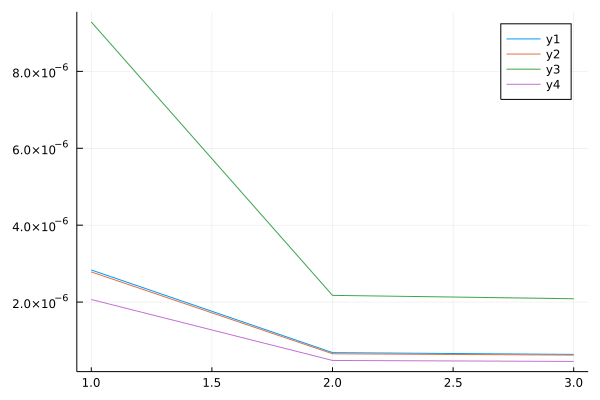

In [46]:
run(sess,loss)
q_check = run(sess,q_t_y)[5];
p_check = run(sess,p);


plot(mean(y_y_list[5],dims=1)[1,:])
# plot!(q_check[:,3,1])
plot!(sum(q_check .* p_check,dims=2)[:,1,1])
plot!(maximum(q_check,dims=2)[:,1,1])
plot!(minimum(q_check,dims=2)[:,1,1])


